# Create MVImgNet bins

This notebook creates the bins for the MVImgNet dataset.

### Running for different categories 

Only need to change CLASS_NUM variable.

All categories we are using in mvimgnet:
`100  113  125  126  152  166  19  196  46  57  60  7  70  8  99`

Class `23` was excluded as it's biggest max angle = 84.257

In [ ]:
CLASS_NUM = 152


In [2]:
from pathlib import Path

CONFIG = {
    "colmap_script": Path("../colmap/scripts/python"),
    "input_path": Path("../datasets/mvimgnet"),
    "output_path": Path("../datasets/split_angles_mvimgnet"),
    "angle_bins": [0, 15, 30, 45, 60, 75, 90],
    "class_labels": {7: "Stove", 8: "Sofa", 19: "Microwave", 46: "Bed",
                     57: "Toy Cat", 60: "Toy Cow", 70: "Toy Dragon",
                     99: "Coat Rack", 100: "Guitar Stand", 113: "Ceiling Lamp",
                     125: "Toilet", 126: "Sink", 152: "Strings",
                     166: "Broccoli", 196: "Durian"},
    "class_n_images": {100: 218, 113: 154, 125: 58, 126: 30, 152: 192,
                       166: 210, 19: 120, 196: 758, 46: 23, 57: 783,
                       60: 735, 7: 197, 70: 627, 8: 91, 99: 97},
}


ORIGINAL_CLASS_FOLDER_PATH = CONFIG["input_path"] / str(CLASS_NUM)
ORIGINAL_MASKS_FOLDER_PATH = CONFIG["input_path"] / "masks" / str(CLASS_NUM)
OUTPUT_CLASS_FOLDER_PATH = CONFIG["output_path"] / str(CLASS_NUM)
TXT_FILE_PATH  = OUTPUT_CLASS_FOLDER_PATH / f"{CLASS_NUM}.txt"
CSV_FILE_PATH  = OUTPUT_CLASS_FOLDER_PATH / f"{CLASS_NUM}.csv"
JSON_FILE_PATH = OUTPUT_CLASS_FOLDER_PATH / f"{CLASS_NUM}.json"

# ToDo: Should we make it run for all classes in one go?


### Imports

In [3]:
import os
import csv
import json
import numpy as np
from tqdm import tqdm
import pandas as pd
import sys
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import Image, display
from datetime import datetime


### Obtain the read_write_model from python
In the open-hummingbird-eval, go to colmap, there is a scripts folder with a python which contains read_write_model.py 

The following functions are needed: 
read_images_binary & qvec2rotmat

In [4]:
# Sanity check
assert (CONFIG["colmap_script"] / "read_write_model.py").exists(), \
       f"Missing: {CONFIG['colmap_script']}/read_write_model.py"

# Add the colmap script to the import path; import it
sys.path.append(str(CONFIG["colmap_script"]))
from read_write_model import read_images_binary, qvec2rotmat
print("OK: imported read_images_binary, qvec2rotmat")


OK: imported read_images_binary, qvec2rotmat


### Create paths for the split angle dataset

In [5]:
# Create base output folder for this class
OUTPUT_CLASS_FOLDER_PATH.mkdir(parents=True, exist_ok=True)

# Create angle-bin subfolders
for angle in CONFIG["angle_bins"]:
    (OUTPUT_CLASS_FOLDER_PATH / str(angle) / "img").mkdir(parents=True, exist_ok=True)
    (OUTPUT_CLASS_FOLDER_PATH / str(angle) / "mask").mkdir(parents=True, exist_ok=True)

print("Created:", OUTPUT_CLASS_FOLDER_PATH)


Created: ../datasets/split_angles_mvimgnet/152


In [6]:
# # Creating per class the target output folder
# def setup_paths(class_num, input_path, output_base):
#     class_dir = input_path / str(class_num)  # current image and mask folder path
#     out_dir   = output_base / str(class_num)  # target output folder path
#     out_dir.mkdir(parents=True, exist_ok=True)
#     return class_dir, out_dir

# class_folder_path, output_folder_path = setup_paths(CLASS_NUM, CONFIG["input_path"], CONFIG["output_path"])
# print(class_folder_path, output_folder_path)

In [7]:
# # Creating the angle bin subfolders and output file paths
# def create_outputs_path(class_number, output_path, angle_bin):
    
#     # Naming files that go in the output
#     txt_path  = output_path / f"{class_number}.txt"
#     csv_path  = output_path / f"{class_number}.csv"
#     json_path = output_path / f"{class_number}.json"

#     # Create the angle folders (0-90) in the output folder
#     for i in angle_bin:
#         os.makedirs(output_path / str(i), exist_ok=True)
#         os.makedirs(output_path / str(i) / 'img', exist_ok=True)
#         os.makedirs(output_path / str(i) / 'mask', exist_ok=True)

#     return txt_path, csv_path, json_path

# TXT_FILE_PATH, CSV_FILE_PATH, JSON_FILE_PATH = create_outputs_path(CLASS_NUM, output_folder_path, CONFIG["angle_bins"])
# print(TXT_FILE_PATH, CSV_FILE_PATH, JSON_FILE_PATH)

### Populate angle bins given an angle range

In [8]:
# Finding the angles between images
def compute_angles(images):
    sorted_images = sorted(images.items(), key=lambda item: int(item[1].name.split(".")[0]))
    angles_list = [0]
    
    for i in range(1, len(sorted_images)):
        prev = sorted_images[0][0]
        curr = sorted_images[i][0]

        image1 = images[prev]
        image2 = images[curr]

        R1 = qvec2rotmat(image1.qvec)
        R2 = qvec2rotmat(image2.qvec)

        R_rel = R2 @ R1.T

        angle_rad = np.arccos((np.trace(R_rel) - 1) / 2)
        angle_deg = np.degrees(angle_rad)

        angles_list.append(round(angle_deg, 3))

    return angles_list

In [9]:
# Finding the steps between angles
def compute_steps(angles_list):
    steps_list = []
    for i in range(1, len(angles_list)):
        prev_angle = angles_list[i-1]
        curr_angle = angles_list[i]
        steps_list.append(round(abs(prev_angle-curr_angle), 3))
    return steps_list

In [10]:
# ToDo: simplify/document this function
def compute_and_log_angles(class_folder_path, csv_path, angle_func=compute_angles, step_func=compute_steps):
    """
    Compute angles and steps from COLMAP extrinsics for each image folder,
    write results to CSV, and return nested dictionary with computed values.

    Args:
        class_folder_path (Path): Path to the original image folders for the given class.
        csv_path (Path): Output CSV path.
        angle_func (function): Function to compute angles (e.g., compute_angles).
        step_func (function): Function to compute steps (e.g., compute_steps).

    Returns:
        nested_dic (dict): nested dictionary with angles and steps per image folder.
    """
    # Initialize nested dictionary
    nested_dict = {}

    # Write CSV headers
    with open(csv_path, mode='w', newline='') as file:
        writer = csv.writer(file)
        # Create the Column Headers for the CSV file
        # NOTE: 3D_points is still unused but kept for compatibility
        writer.writerow(['id_img', 'range', 'min_angle', 'min_idx', 'max_angle', 'max_idx', 'num_img', 'step_mean', 'step_std', 'min_step', 'max_step', '3D_points'])

    # Calculate angles with Colmap extrinsics for each image subsequently
    sorted_folder = sorted(os.listdir(class_folder_path))
    print("Total files : ", len(sorted_folder))

    # Loop over image folders
    for filename in tqdm(sorted_folder):
        file_cl_image_folder_path = class_folder_path / filename
        folder_path = file_cl_image_folder_path / 'images/'

        # print(f"Processing folder: {folder_path}")

        # Get image files
        if not os.path.exists(folder_path):
            # skip if no images folder
            print("There is no folder for images: ", folder_path)
            continue

        list_images = []
        for f in os.listdir(folder_path):
            image_name = folder_path / f
            list_images.append(image_name)
        x = np.sort(list_images)  # ToDo: x is not used?

        # ToDo: is something wrong in this case and should we throw an error?
        if not list_images:
            # skip if no images found
            print("There are no images in this folder")
            continue

        # Read COLMAP binary
        # ToDo: why just 'sparse/0/...'? There are 1 and 2 in some folders as well
        bin2 = file_cl_image_folder_path / 'sparse/0/images.bin'
        if not os.path.exists(bin2):
            # skip sparse folder that don't have colmap stats
            # ToDo: is it ok to not have COLMAP statistics?
            print("The sparse folder does not contain COLMAP statistics")
            continue
        
        images = read_images_binary(bin2)

        # Compute angles & steps
        angle_list = angle_func(images)
        step_list = step_func(angle_list)

        # Collect stats
        min_angle = min(angle_list)
        max_angle = max(angle_list)
        idx_min_angle = np.argmin(angle_list)
        idx_max_angle = np.argmax(angle_list)

        dic = {
            'angles': angle_list,
            'step': step_list
        }

        nested_dict[filename] = dic

        # Write per row in csv.file
        with open(csv_path, mode='a', newline='') as file:
            writer = csv.writer(file)
            step_mean = float(np.round(np.mean(step_list), 2))
            step_std = float(np.round(np.std(step_list), 2))
            min_step = float(np.round(np.min(step_list), 2))
            max_step = float(np.round(np.max(step_list), 2))

            writer.writerow([filename,
                             abs(round(min_angle, 3) - round(max_angle, 3)),
                             round(min_angle, 3), idx_min_angle,
                             round(max_angle, 3), idx_max_angle,
                             len(list_images),
                             step_mean, step_std,
                             min_step, max_step])  # placeholder for 3D_points column if needed

    return nested_dict


nested_dic = compute_and_log_angles(ORIGINAL_CLASS_FOLDER_PATH, CSV_FILE_PATH)

# Write the nested dictionary to a binary file
with open(JSON_FILE_PATH, 'w') as file:
    json.dump(nested_dic, file, indent=2)

Total files :  225


  0%|          | 0/225 [00:00<?, ?it/s]

100%|██████████| 225/225 [00:24<00:00,  9.18it/s]


#### What is the stucture of the JSON file?

```
{
  "some_id": {
    "angles": [...],
    "step": [...]
  },
  "another_id": {
    "angles": [...],
    "step": [...]
  },
  ...
}
```

1. Keys (like "00000b90", "00001d21", etc.):
    1. These are identifiers (likely strings from filenames, image IDs, sample IDs, etc.).
    2. Every ID corresponds to one object/entity.
2. Values (dictionaries with "angles" and "step"):
    1. Each ID maps to a dictionary with:
      1. "angles": A list of floats for the computed rotation angles of each image in that folder, relative to the first image (in degrees).
      2. "step": A list of floats for the differences between consecutive angles (how much the view changed between each image).


##### Example Entry:
```
"00000b90": {
  "angles": [0, 3.831, 9.897, 15.838, ...],
  "step": [3.831, 6.066, 5.941, 6.274, ...]
},
  "00001d21": {
    "angles": [
      0,
      0.374,
      1.748,
      4.001, ...
    ],
    "step": [
      0.374,
      1.374,
      2.253,
      3.397, ...
    ]
  }
```

In [11]:
def filter_folders_by_max_angle(csv_path, txt_path, largest_angle):
    """
    Select the folders from the CSV file where 'max_angle' >= largest_angle,
    and write them (one per line) into a TXT file.
    The TXT file is overwritten on each run.

    Parameters:
    - csv_path (str): Path to the CSV file.
    - txt_path (str): Path to the output TXT file.
    - largest_angle (float): Threshold to filter 'max_angle'.
    """

    df = pd.read_csv(csv_path)
    ids_to_write = df.loc[df['max_angle'] >= largest_angle, 'id_img']

    if ids_to_write.empty:
        max_angle = df['max_angle'].max()
        raise ValueError(
            f"No valid folders for max_angle={max_angle} < threshold={largest_angle}. "
            f"TXT not created."
        )

    # Overwrite the TXT file to avoid duplicates across runs
    with open(txt_path, 'w') as f:
        for img_id in ids_to_write:
            f.write(f"{img_id}\n")


LARGEST_ANGLE = CONFIG["angle_bins"][-1]
filter_folders_by_max_angle(CSV_FILE_PATH, TXT_FILE_PATH, LARGEST_ANGLE)

with open(TXT_FILE_PATH, "r") as f:
    data = [line.strip() for line in f if line.strip()]
print(f"Wrote {len(data)} folder names to {TXT_FILE_PATH}")

Wrote 192 folder names to ../datasets/split_angles_mvimgnet/152/152.txt


In [12]:
def process_and_link_images(
    class_image_folder_path,
    class_mask_folder_path,
    output_folder_path,
    json_path=JSON_FILE_PATH,
    txt_path=TXT_FILE_PATH,
    angle_bins=CONFIG["angle_bins"],
):
    """
    Build a normalized dataset for a given class by linking (image, mask) pairs
    to canonical angle folders.

    For each ID in txt_path we:
      - load its per-frame viewing angles from json_path
      - load all original RGB frames (.jpg) and masks (.png)
      - match images and masks by base ID (e.g. "001" from "001.jpg" and "001.jpg.png")
      - for each target angle in angle_bins, pick the closest frame (among pairs that
        have both image and mask) and create symlinks into:
            <output>/<angle>/img/<captureID>_<image_name>
            <output>/<angle>/mask/<captureID>_<mask_name>
      - accumulate the angular error (chosen_angle - target_angle)

    Args:
    - class_image_folder_path (Path): path to the original image folders for the class
    - class_mask_folder_path (Path): path to the original mask folders for the class
    - output_folder_path (Path): path to the target output folder for the class
    - json_path (str): path to the JSON file with precomputed per-frame angles
    - txt_path (str): path to the TXT file with capture IDs to process
    - angle_bins (list[float]): target angles for binning

    Returns:
    - data (list[str]): capture IDs read from txt_path
    - std_err (float): std of angle error across all chosen frames
    - mean_err (float): mean angle error across all chosen frames
    """

    # Load precomputed per-frame camera angles for each folder
    with open(json_path, "r") as f:
        nested_dict = json.load(f)

    # The TXT lists the subfolder names we want to process (e.g. "26000111", ...)
    if not os.path.exists(txt_path):
        raise ValueError(f"{txt_path} does not exist. Regenerate it or drop this class.")
    with open(txt_path, "r") as f:
        data = [line.strip() for line in f if line.strip()]
    if not data:
        raise ValueError("TXT file is empty, nothing to process.")

    tot_err = []
    for img_folder in tqdm(data):
        # Expected structure:
        #   <class_image_folder_path>/<img_folder>/images/      (RGB frames, *.jpg)
        #   <class_mask_folder_path>/<img_folder>               (masks, *.png)
        img_folder_rel = Path(img_folder)
        imgs_path = class_image_folder_path / img_folder_rel / "images"
        masks_path = class_mask_folder_path / img_folder_rel


        # Collect all original frames (sorted, stable order):
        #   - images: *.jpg, ignore *_bg_removed.*
        #   - masks : *.png, ignore *_bg_removed.*
        images = [
            f for f in sorted(os.listdir(imgs_path))
            if f.lower().endswith(".jpg")
            and "_bg_removed" not in f
        ]
        masks = [
            f for f in sorted(os.listdir(masks_path))
            if f.lower().endswith(".png")
            and "_bg_removed" not in f
        ]

        if not images:
            raise RuntimeError(f"{img_folder}: no images in {imgs_path}")
        if not masks:
            raise RuntimeError(f"{img_folder}: no masks in {masks_path}")

        # Check the counts of the per-frame camera angles.
        # These should be aligned with the original image sequence.
        if img_folder not in nested_dict:
            raise RuntimeError(
                f"{img_folder} not found in JSON {json_path}. "
                "Check that angle metadata was computed for this capture."
            )
        angles_full = nested_dict[img_folder]["angles"]
        if len(angles_full) != len(images):
            raise RuntimeError(
                f"{img_folder} contains {len(images)} images but {len(angles_full)} angles "
                f"(images: {imgs_path})"
            )

        # Image IDs: "001.jpg" -> "001"
        img_ids = [Path(n).stem for n in images]
        # Mask IDs: "001.jpg.png" -> Path(...).stem = "001.jpg" -> split(".")[0] -> "001"
        mask_ids = [Path(n).stem.split(".")[0] for n in masks]

        img_set = set(img_ids)
        mask_set = set(mask_ids)
        common_ids = sorted(img_set & mask_set)

        # Log non-matching IDs  (captures that have only an image or only a mask).
        # In MVImgNet we sometimes see extra masks (e.g. 001–031 masks vs 001–020 images).
        if img_set != mask_set:
            only_in_imgs = sorted(img_set - mask_set)
            only_in_masks = sorted(mask_set - img_set)
            print(
                f"[WARN] {img_folder}: {len(images)} images vs {len(masks)} masks "
                f"(images: {imgs_path}, masks: {masks_path})"
            )
            if only_in_imgs:
                print("  IDs only in images:", ", ".join(only_in_imgs))
            if only_in_masks:
                print("  IDs only in masks :", ", ".join(only_in_masks))

        if not common_ids:
            print(f"[SKIP] {img_folder}: no matching image/mask IDs after filtering")
            continue

        # Map ID to image filename, mask filename, and angle (for IDs that have both).
        # Note that we do not expect IDs outside common_ids here.
        img_by_id = {id_: fname for id_, fname in zip(img_ids, images) if id_ in common_ids}
        angle_by_id = {id_: ang for id_, ang in zip(img_ids, angles_full) if id_ in common_ids}
        mask_by_id = {id_: fname for id_, fname in zip(mask_ids, masks) if id_ in common_ids}

        # For each canonical angle (0, 15, 30, ...), pick the ID whose angle is closest,
        # restricted to IDs that have BOTH image and mask.
        for target_angle in angle_bins:
            best_id = min(
                common_ids,
                key=lambda id_: abs(angle_by_id[id_] - target_angle),
            )

            tot_err.append(angle_by_id[best_id] - target_angle)

            img_name = img_by_id[best_id]
            mask_name = mask_by_id[best_id]

            # Create normalized layout:
            #   <output>/<angle>/img/<folderID>_<image_name>
            #   <output>/<angle>/mask/<folderID>_<mask_name>
            dst_img_dir = output_folder_path / f"{target_angle}/img"
            dst_mask_dir = output_folder_path / f"{target_angle}/mask"
            dst_img_dir.mkdir(parents=True, exist_ok=True)
            dst_mask_dir.mkdir(parents=True, exist_ok=True)

            dst_img = dst_img_dir / f"{img_folder}_{img_name}"
            if dst_img.exists() or dst_img.is_symlink():
                dst_img.unlink()
            dst_img.symlink_to((imgs_path / img_name).resolve())

            dst_mask = dst_mask_dir / f"{img_folder}_{mask_name}"
            if dst_mask.exists() or dst_mask.is_symlink():
                dst_mask.unlink()
            dst_mask.symlink_to((masks_path / mask_name).resolve())

    if not tot_err:
        raise RuntimeError("No valid images/masks were linked. Check TXT content and paths.")

    std_err = round(np.std(tot_err), 2)
    mean_err = round(np.mean(tot_err), 2)
    print(f"Angle error mean: {mean_err}")
    print(f"Angle error std:  {std_err}")

    return data, std_err, mean_err


In [13]:
data, std, mean = process_and_link_images(ORIGINAL_CLASS_FOLDER_PATH, ORIGINAL_MASKS_FOLDER_PATH, OUTPUT_CLASS_FOLDER_PATH)


 97%|█████████▋| 187/192 [00:12<00:00, 10.76it/s]

[WARN] 1b016bf0: 22 images vs 31 masks (images: ../datasets/mvimgnet/152/1b016bf0/images, masks: ../datasets/mvimgnet/masks/152/1b016bf0)
  IDs only in masks : 001, 002, 003, 004, 005, 006, 007, 008, 009


100%|██████████| 192/192 [00:31<00:00,  6.07it/s]

Angle error mean: 0.03
Angle error std:  1.25


In [14]:
def log_errors(mean_error, std_error, num_images_processed, class_num, class_cat, output_folder_path, csv_folder, global_log_csv='processing_log.csv'):
    # Global CSV log entry
    log_entry = {
        'run_timestamp': datetime.now().strftime("%Y-%m-%d %H:%M"),
        'class_num': class_num,
        'class_category' : class_cat,
        'std_error': std_error,
        'mean_error': mean_error,
        'num_images_processed': num_images_processed
    }

    log_df = pd.DataFrame([log_entry])

    # Append to global log CSV
    path_log_csv = os.path.join(csv_folder, global_log_csv)
    if os.path.exists(path_log_csv):
        log_df.to_csv(path_log_csv, mode='a', header=False, index=False)
    else:
        log_df.to_csv(path_log_csv, index=False)

    # Local stats summary per class
    summary_file = os.path.join(output_folder_path, 'stats_summary.txt')
    with open(summary_file, 'w') as f:
        f.write(f"Class: {class_num}\n")
        f.write(f"Mean error: {mean_error:.2f} degrees\n")
        f.write(f"Std error: {std_error:.2f} degrees\n")
        f.write(f"num_images_processed: {num_images_processed} img\n")

    print(f'Logged errors for class {class_num} to global CSV and summary file.')

log_errors(mean, std, len(data), CLASS_NUM, CONFIG["class_labels"][CLASS_NUM], OUTPUT_CLASS_FOLDER_PATH, CONFIG["output_path"])


Logged errors for class 152 to global CSV and summary file.


In [15]:
def plot_class_angle_histogram(class_number, histogram_bins = 100):
    output_path = CONFIG["output_path"]
    class_labels = CONFIG["class_labels"]

    if class_number not in class_labels:
        raise ValueError(f"Class number {class_number} is not in the class mapping.")

    category = class_labels[class_number]
    output_folder = output_path / f"{class_number}/"
    CSV_PATH = output_folder / f"{class_number}.csv"

    if not os.path.exists(CSV_PATH):
        raise FileNotFoundError(f"CSV file not found: {CSV_PATH}")

    df = pd.read_csv(CSV_PATH)
    print(f"Loaded CSV with {df.shape[0]} rows.")

    if 'max_angle' not in df.columns:
        raise ValueError(f"'max_angle' column not found in {CSV_PATH}")

    # Optional: Downsample if too large (e.g., > 100,000 rows)
    if df.shape[0] > 100000:
        df = df.sample(100000, random_state=42)
        print("Data was downsampled to 100,000 rows for performance.")

    sns.histplot(df['max_angle'], bins= histogram_bins, kde=True, color='green', edgecolor='gray')

    plt.xlabel('Angle in degrees')
    plt.ylabel(f'Instances of class {class_number}: \"{category}\"')
    plt.axvline(x=90, color='red', linestyle='--', label='90 degrees')
    plt.legend()
    plt.title(f'Class {class_number} \"{category}\": max angle histogram')
    plt.tight_layout()

    # Save plot
    plot_filename = os.path.join(output_folder, f"{class_number}_angle_histogram.png")
    plt.savefig(plot_filename)
    print(f"Plot saved as: {plot_filename}")
    plt.close()

    return plot_filename

Loaded CSV with 225 rows.
Plot saved as: ../datasets/split_angles_mvimgnet/152/152_angle_histogram.png


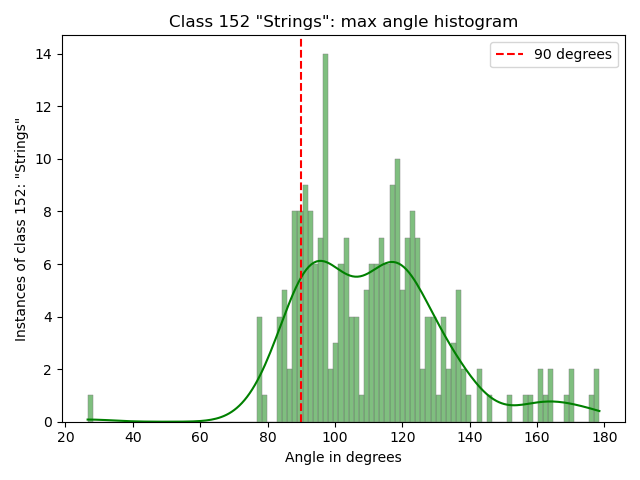

In [16]:
# Create the histogram for the CLASS explored
histogram_path = plot_class_angle_histogram(CLASS_NUM)
display(Image(filename=histogram_path))

In [17]:
rows = []
angle_cols = [f"{a}°" for a in CONFIG["angle_bins"]]

for cls_id, cls_name in CONFIG["class_labels"].items():
    row = {"class_id": cls_id, "class_name": cls_name}
    for angle in CONFIG["angle_bins"]:
        angle_dir = CONFIG["output_path"] / str(cls_id) / str(angle) / "img"
        row[f"{angle}°"] = (
            sum(1 for f in os.listdir(angle_dir) if f.endswith(".jpg"))
            if angle_dir.is_dir() else 0
        )
    row["expected_per_angle"] = CONFIG["class_n_images"].get(cls_id)
    rows.append(row)

df_counts = pd.DataFrame(rows).sort_values("class_id")
df_counts


,class_id,class_name,0°,15°,30°,45°,60°,75°,90°,expected_per_angle
0,7,Stove,197,197,197,197,197,197,197,197
1,8,Sofa,91,91,91,91,91,91,91,91
2,19,Microwave,120,120,120,120,120,120,120,120
3,46,Bed,23,23,23,23,23,23,23,23
4,57,Toy Cat,783,783,783,783,783,783,783,783
5,60,Toy Cow,735,735,735,735,735,735,735,735
6,70,Toy Dragon,627,627,627,627,627,627,627,627
7,99,Coat Rack,97,97,97,97,97,97,97,97
8,100,Guitar Stand,218,218,218,218,218,218,218,218
9,113,Ceiling Lamp,154,154,154,154,154,154,154,154


In [18]:
mismatch_found = False

for _, row in df_counts.iterrows():
    expected = row["expected_per_angle"]
    if pd.isna(expected):
        continue  # no expected value for this class

    mismatched_angles = [
        col for col in angle_cols
        if row[col] != expected
    ]

    if mismatched_angles:
        mismatch_found = True
        print(
            f"class {int(row['class_id'])} ({row['class_name']}), "
            f"expected {int(expected)}, mismatches: "
            + ", ".join(f"{col}={int(row[col])}" for col in mismatched_angles)
        )

if mismatch_found:
    raise ValueError("Found per-angle count mismatches.")

